# Using BAMBI's ability to import distributions from base PYMC to handle unusual count data

Bambi is an extension to PYMC that allows the user to use Wilkinson-style notation and simple methods to fit simple and complex (hierachical models with varying structus) models and covariates with relative ease compared to base PYMC. Tomi Capretti and the team deserve kudos for making Bayesian methods accessable to the wider pool of Bayesians like myself who are not statisticians but people who realize the power of Bayesian inference and want to use it in the real world. The flexibility of Bambi is amazing, I want to showcase this flexibility by showing the feature where a user can grab a distribution from PYMC that is not included in the menu of distributions (aka "families") currently supported by default. 

In [1]:
# load the libraries we wil need

import arviz as az
import bambi as bmb
import pymc as pm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

We will work with a dataset of the number of "likes" of comments on some Youtube music videos. This data is challenging because of contemporaneous under and over-dispersion. 

In [2]:
data = pd.read_csv('youtube_dataset.csv')

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19300 entries, 0 to 19299
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Video Name    19300 non-null  object
 1   Channel Name  19300 non-null  object
 2   Comment Id    19300 non-null  object
 3   User Name     19299 non-null  object
 4   Comment       19300 non-null  object
 5   Date          19300 non-null  object
 6   Likes         19300 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 1.0+ MB


,Video Name,Channel Name,Comment Id,User Name,Comment,Date,Likes
0,Luis Fonsi - Despacito ft. Daddy Yankee,LuisFonsiVEVO,UgwV0tapZzaFxdYm1z14AaABAg,GAMIT yuvraj,The people who liked this comment is officiall...,2020-08-10T20:00:43Z,98280
1,Luis Fonsi - Despacito ft. Daddy Yankee,LuisFonsiVEVO,UgyiccblP3A16aixpit4AaABAg,MrCrazy,"- Wait, it's 7B views\n- Always has been",2020-09-07T20:52:36Z,773
2,Luis Fonsi - Despacito ft. Daddy Yankee,LuisFonsiVEVO,Ugx7THW3EBNJlhJuwSB4AaABAg,60K Subs With 1 Video Challenge,*Teacher: What is the population of the Earth?...,2019-11-21T03:23:32Z,356081
3,Luis Fonsi - Despacito ft. Daddy Yankee,LuisFonsiVEVO,UgzXUsI6yrRjTKNASf94AaABAg,Srivathsa D,Let's be honest this wasn't your recommendatio...,2020-09-09T03:41:34Z,13
4,Luis Fonsi - Despacito ft. Daddy Yankee,LuisFonsiVEVO,UgxCu6mywg6uqjueHQ14AaABAg,1k Subscribers Challenge Without Any Video,Types Of People:\n10% Enjoying Song \n90% Chec...,2020-09-08T09:53:24Z,122


If we take a look at the data we can see that, in terms of frequency, the data is has high zero-inflation (i.e. many comments don't get any likes), most "like" have a count of under approximately 5,000 - but that some comments have "like" counts far larger - up to about 500,000. We can say this data shows bother under-dispersion (the high number of zero "like" counts) and over-dispersion (wide range of "like" counts) 

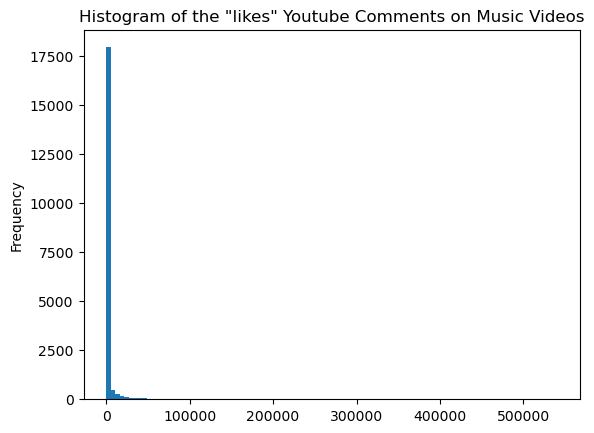

In [3]:
data.Likes.plot(kind='hist', bins=100)
plt.title('Histogram of the "likes" Youtube Comments on Music Videos');

The number of zero "like" counts

In [4]:
data.loc[data.Likes == 0].Likes.count()

1540

The number of "like" counts between 0 and 10,000

In [5]:
data.loc[data.Likes.between(0, 10_000)].Likes.count()

18344

The proportion of "like" counts between 0, and 10,000 is 23%

In [6]:
(data.loc[data.Likes.between(0, 10_000)].Likes.sum() / data['Likes'].sum()).round(2)

0.23

Showing a cumulative sum of the number of "like" counts shows how heavily skewed to the extreme values the comment "like" counts are

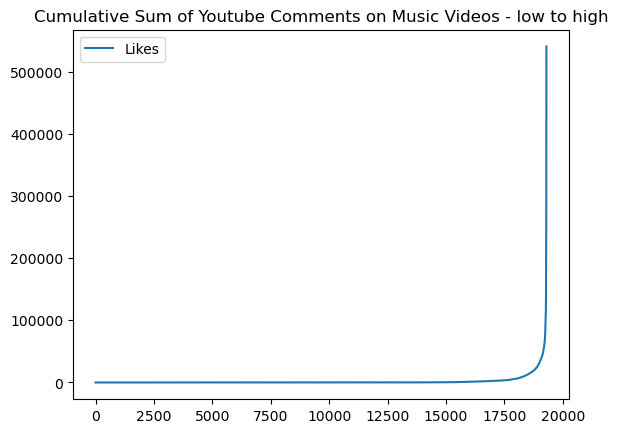

In [7]:
data[['Likes']].sort_values(by=['Likes']).reset_index(drop=True).plot(kind='line')
plt.title('Cumulative Sum of Youtube Comments on Music Videos - low to high');

The top "like" counts of 1,000 comments make up 78% of all "likes"

In [8]:
( data.sort_values(by=['Likes'], ascending=False).head(1000).Likes.sum() / data.Likes.sum() ).round(2)

0.78

The arithmetical mean:

In [9]:
data.Likes.mean().round(0)

2142.0

## Fit in BAMBI using the Negative Binomial Distribution

The model is very simple and is basically trying to estimate the mean, which because of non-normality, zero-inflation, and a fat tail, would not make sense using a simple arithmetical mean

In [10]:
# build the model using Wilkison/NLME notation, we will use the negative binomial distribution

model_nb = bmb.Model("Likes ~ 1", data, family='negativebinomial')

# print out the model
model_nb

Formula: Likes ~ 1
Family name: Negativebinomial
Link: log
Observations: 19300
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 2.5)

  Auxiliary parameters
    alpha ~ HalfCauchy(beta: 1)

Fit the model using BAMBI's fit function -- the model fits without divergences. Afterwords create the posterior predictive samples using Bambi's inbuilt prediction function

In [11]:
idata_nb = model_nb.fit(chains=4, cores=4, target_accept=.95, include_mean=True)

model_nb.predict(idata_nb, kind='pps')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Likes_alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


The Negative Binomial distribution, which usually does a good job of handing over-dispersion, cannot handle the heavy tail, and the posterior predictive is not doing a good job of capturing the observed data's shape

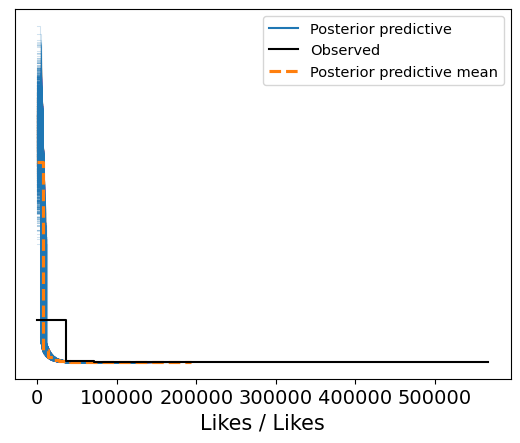

In [12]:
az.plot_ppc(idata_nb, kind='kde');

## Fit in BAMBI using the Discrete Weibull distribution

The Discrete Weibull is flexible distribution that can handle both under and over-dispersion in count data

Since the distribution does not come included in Bambi, we build it using BAMBI's Family, Likehood, and Prior objects. We create the family, add the likelihood object for the Discrete Weibull, as well as the link function (here a "logit"). The Discrete Weibull has two parameters, q and beta. q handles the zero inflation and must be between, but not include, 0 and 1 (or 0% and 100%). beta is a shape parameter and essentially tells the distribution how far to the right it must go. We have to tell BAMBI which is the parent and which is the auxillary parameter. Here the parent is the beta, because it carries most of the information, whereas q handles the zero-inflation. We have to provider a prior for q and here I choose a non-informative Beta distribution. The data should provide enough information.

In [13]:
beta_prior = bmb.Prior("Beta", alpha=1, beta=1)
likelihood = bmb.Likelihood("DiscreteWeibull", parent='beta', q=beta_prior)
family = bmb.Family("Discrete Weibull", likelihood, "log")

Now we build the model as we did with the Negative Binomial

In [14]:
model_dw = bmb.Model("Likes ~ 1", data, family=family)

model_dw

Formula: Likes ~ 1
Family name: Discrete weibull
Link: log
Observations: 19300
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 2.5)

  Auxiliary parameters
    q ~ Beta(alpha: 1, beta: 1)

Here is a trick part. Since the Discrete Weibull does not come included in BAMBI, we cannot use the predict function. So, we use the ".build" function of BAMBI to render the model for PYMC, and then we use the PYMC context to sample. This will allow us to lean on PYMC's posterior predictive functionality directily.

In [15]:
model_dw.build()

In [16]:
with model_dw.backend.model as model_dw:

  idata_dw = pm.sample(chains=4, cores=4, target_accept=.95)

  pm.sample_posterior_predictive(idata_dw, extend_inferencedata=True, random_seed=1234, keep_size=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Likes_q]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


The Discrete Weibull does a far better job than the Negative Binomial in capaturing the the shape of the observed data, including the zero-inflation, and the heavy tail (even allowing for up to 2 billion likes of a comment). This might be extreme but not outside the bounds of possibility!

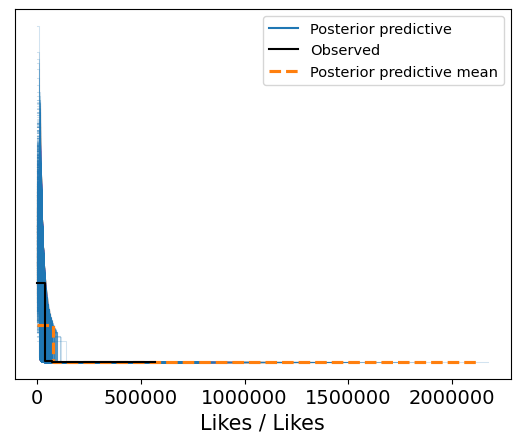

In [17]:
fig, ax = plt.subplots()
az.plot_ppc(idata_dw, kind='kde', ax=ax)
ax.ticklabel_format(useOffset=False, style='plain');

We can compare the models. As expected, the Discrete Weibull is better accoring to LOO.

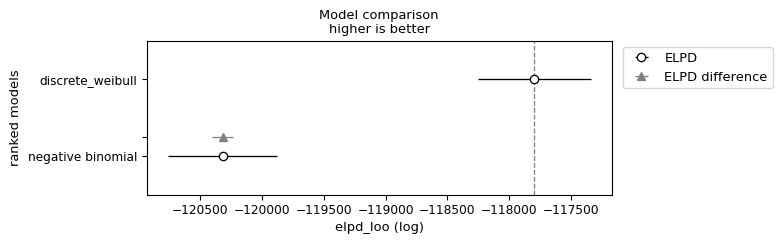

In [18]:
compare_dict = {"negative binomial": idata_nb, "discrete_weibull": idata_dw}

az.plot_compare(az.compare(compare_dict));

Finally, let's take a look at those means. The Negative Binomial arrives at near the arithmetical mean because it does not do a good job of handing either dispersions. However, the Discrete Weibull gives a better estimate, basically lower at the low-end (due to zero inflation), and higher on higher on the high-end. 

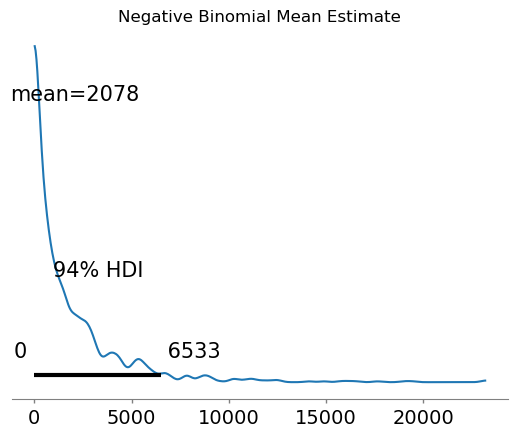

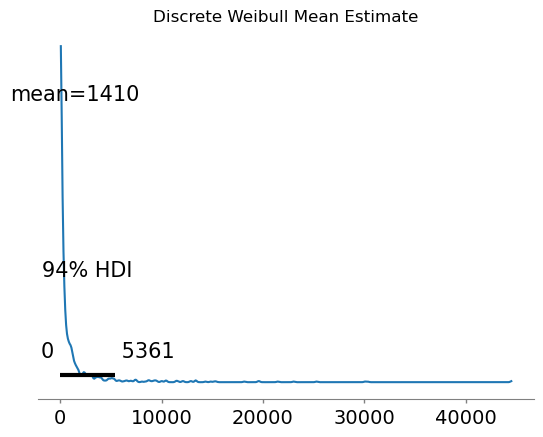

In [19]:
az.plot_posterior(idata_nb.posterior_predictive.Likes[:, :, 1].mean(axis=0))
plt.title('Negative Binomial Mean Estimate')

az.plot_posterior(idata_dw.posterior_predictive.Likes[:, :, 1].mean(axis=0))
plt.title('Discrete Weibull Mean Estimate');